# cleaning fair housing dataset and extracting non-compliant samples

In [7]:
import json

def load_jsonl(path):
    data = []
    with open(path, 'r') as f:
        for line in f:
            data.append(json.loads(line))
    return data
        

non_compliant_queries = load_jsonl('data/fairhousing.json')
non_compliant_queries = [x for x in non_compliant_queries if x['label'] == 'non-compliant']

## save queries in a txt file

In [8]:
def write_txt(q_list, path):
    with open(path, 'w') as f:
        for ex in q_list:
            f.write(f"{ex}\n")


queries = [x['content'] for x in non_compliant_queries]

write_txt(queries, 'data/non-compliant-queries.txt')

# Data Preprocessing

## convert query responses to chat format

In [1]:

import json 

def convert_single_turn_query_response_to_chat_format(path, split=''):
    data = []
    with open(path, 'r') as f:
        for line in f:
            data.append(json.loads(line))
    
    chat_data = []
    for ex in data:
        cur_chat = []
        cur_chat.append({'role': 'user', 'content': ex['query']})
        cur_chat.append({'role': 'assistant', 'content': ex['response']})
        if split == 'instructions' or split == 'dialog':
            chat_data.append({'messages': cur_chat, 'split': split, 'topic': ex['topic']})
        else:
            chat_data.append({'messages': cur_chat, 'split': split})
    return chat_data
    
    
non_comp_data_chat = convert_single_turn_query_response_to_chat_format('data/safety.json', split='safety')
    
with open('data/safety_all_chat.json', 'w') as f:
    for chat in non_comp_data_chat:
        f.write(json.dumps(chat) + '\n')
        

## data pruning

In [2]:
from tqdm import tqdm
from sentence_transformers import SentenceTransformer
import numpy as np


sim_model = SentenceTransformer("all-mpnet-base-v2")

def get_example_str(example, query_only=True):
    res = ""
    for m in example['messages']:
        content = m['content']
        if query_only:
            if m['role'] == 'user':
                res += f"{content}\n"
        else:
            res += f"{content}\n"
    return res


def prune_data(examples, threshold=0.9, query_only=True):
    print('initial data size: ', len(examples))
    
    np.random.shuffle(examples)
    
    pruned_data = []
    pruned_data_embs = None
    
    emb_dict = {}
    
    data_str = [get_example_str(d) for d in examples]
    data_emb = sim_model.encode(data_str, batch_size=256, show_progress_bar=True)
    
    # build sim dict
    for ex, emb in zip(data_str, data_emb):
        emb_dict[ex] = emb
    
    
    for ex in tqdm(examples):
        ex_str = get_example_str(ex)
        
        cur_emb = emb_dict[ex_str]
        
        if len(pruned_data) == 0:
            pruned_data.append(ex)
            pruned_data_embs = np.array([cur_emb])
            continue
            
        sim_mat = cur_emb.reshape(1, -1) @ pruned_data_embs.T
        max_sim = np.sort(sim_mat, axis=-1)[0, -1]
        
        if max_sim > threshold:
            continue
        
        pruned_data.append(ex)
        pruned_data_embs = np.concatenate([pruned_data_embs, cur_emb.reshape(1, -1)], axis=0)
        
    print("pruned data size: ", len(pruned_data))
    
    return pruned_data
    


/Users/navidm/miniconda3/envs/compllm/lib/python3.10/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange
/Users/navidm/miniconda3/envs/compllm/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [3]:

non_comp_data_chat = prune_data(non_comp_data_chat, threshold=0.9)

with open('data/safety_all_chat.json', 'w') as f:
    for chat in non_comp_data_chat:
        f.write(json.dumps(chat) + '\n')

initial data size:  5


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 32922.32it/s]

pruned data size:  5


## analyze single-turn instruction following data

In [4]:
import json
import seaborn as sns

data = []
with open('data/general_instructions.json', 'r') as f:
    for line in f:
        data.append(json.loads(line))
        
topics = [d['topic'] for d in data]

from collections import Counter

c = Counter(topics)

instructions = [d['query'] for d in data]

print(f"total instructions: {len(instructions)}")
print(f"total unique instructions: {len(set(instructions))}")


total instructions: 6
total unique instructions: 6


In [5]:
with open('data/unique_general_instructions.json', 'w') as f:
    cleaned_data = []
    queries = {}
    for ex in data:
        if ex['query'] not in queries:
            queries[ex['query']] = 1
            cleaned_data.append({'query': ex['query'], 'response': ex['response'], 'topic': ex['topic']})
    for ex in cleaned_data:
        f.write(json.dumps(ex) + '\n')
        
print(len(cleaned_data))

6


### visualize topics and sub-topics

Text(0.5, 1.0, 'top-50 topic counts')

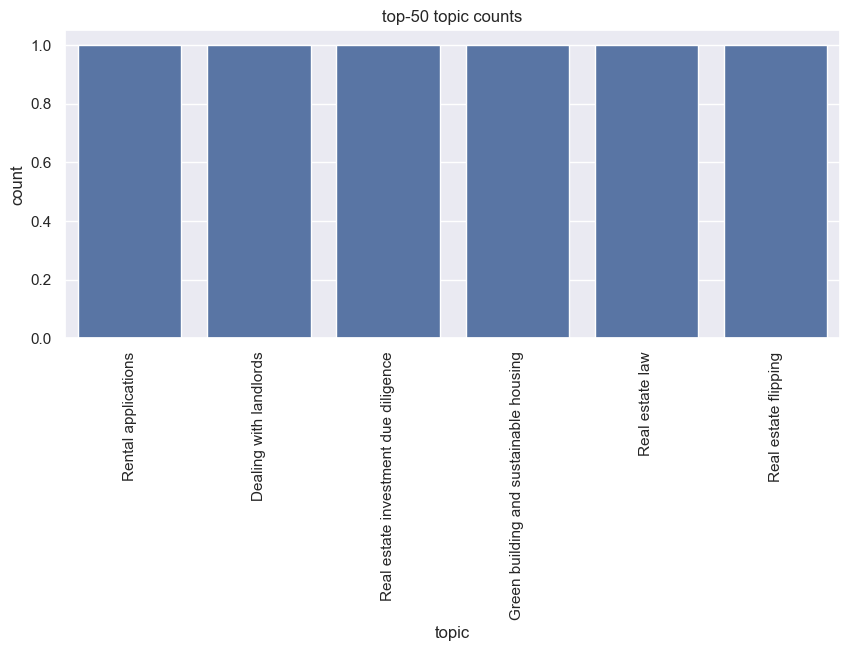

In [6]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme()

df = pd.DataFrame(c.most_common(50), columns=['topic', 'count'])
plt.figure(figsize=(10,4))
sns.barplot(df, x='topic', y='count')
plt.xticks(rotation=90)
plt.title("top-50 topic counts")

In [7]:
import re

def process_subtopics(subtopics_text):
    items = re.findall(r'^\d+\.\s*(.+)$', subtopics_text, re.MULTILINE)
    return [i.strip() for i in items]


process_subtopics(data[0]['subtopics'])

['Understanding rental application forms',
 'Common requirements for rental applications',
 'The importance of credit checks in rental applications',
 'How to fill out a rental application correctly',
 'Screening tenants: What landlords look for',
 'The role of rental history in applications',
 'How to provide proof of income for a rental application',
 'The impact of criminal background checks on applications',
 'Fair Housing Act and rental applications',
 'Tips for writing a cover letter for your rental application',
 'The significance of references in rental applications',
 'Managing application fees: What to know',
 'The timeline for rental application approval',
 'How to appeal a denied rental application',
 'Online rental applications vs. paper applications',
 'The role of guarantors in rental applications',
 'How to handle multiple rental applications',
 'Rental application red flags for landlords',
 'How to prepare for a rental application interview',
 'The legalities of rental

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


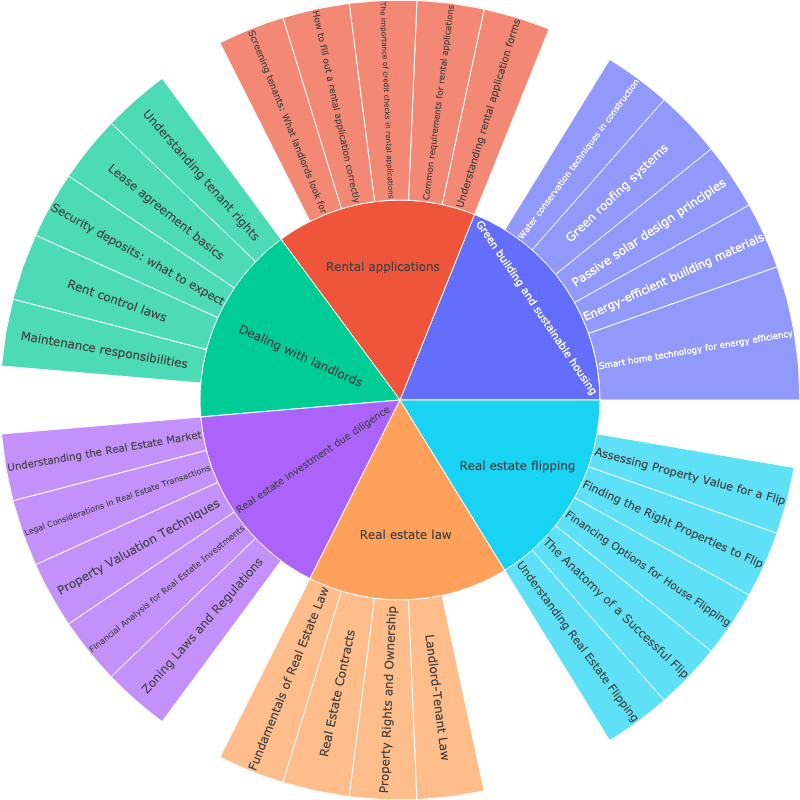

In [8]:
import plotly.graph_objects as go
import plotly.io as pio
import plotly.offline as pyo

topics_dict = {k: Counter() for k in topics}

def process_subtopics(subtopics_text):
    items = re.findall(r'^\d+\.\s*(.+)$', subtopics_text, re.MULTILINE)
    return [i.strip() for i in items]

for d in data:
    subs = process_subtopics(d['subtopics'])
    topics_dict[d['topic']].update(subs)


# Set notebook mode to work in offline
# pyo.init_notebook_mode()
# Enable Plotly for Jupyter notebook
pio.renderers.default = 'png'

labels = []
parents = []
values = []

tc_mc = c.most_common(15)
topic_names = [t[0] for t in tc_mc]
# Add main topics
for topic, count in tc_mc:
    labels.append(topic)
    parents.append("")
    values.append(count)

for topic, subtopics in topics_dict.items():
    if topic not in topic_names:
        continue
    for subtopic, subcount in subtopics.most_common(5):
        
        labels.append(subtopic)
        parents.append(topic)
        values.append(subcount)

fig = go.Figure(go.Sunburst(
    labels=labels,
    parents=parents,
    values=values,
    # branchvalues="total",
))


fig.update_layout(
    margin=dict(t=0, l=0, r=0, b=0),
    width=800,  # Set the width here
    height=800 
)

# fig.write_image("topic-pie.png")
# Show the pl
fig.show()

## convert instruction response pairs to chat format

In [9]:
instructions_chat = convert_single_turn_query_response_to_chat_format('data/unique_general_instructions.json', split='instructions')
instructions_chat = prune_data(instructions_chat, threshold=0.9)


with open('data/general-instructions-chat-all.json', 'w') as f:
    for chat in instructions_chat:
        f.write(json.dumps(chat) + '\n')

initial data size:  6


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 41734.37it/s]

pruned data size:  6


## analyze dialog data

In [10]:
import json

raw_data = []

with open('data/dialogs.json', 'r') as f:
    for line in f:
        raw_data.append(json.loads(line))
        
raw_data[0]
    

{'topic': 'HOAs',
 'response': "### 50 Possible Scenarios of Conversation about HOAs\n\n1. Understanding the role of an HOA\n2. Benefits of living in a community with an HOA\n3. Common HOA fees and what they cover\n4. How to find an HOA in a neighborhood\n5. Differences between mandatory and voluntary HOAs\n6. What to do if you disagree with HOA rules\n7. The process of running for an HOA board\n8. Understanding HOA bylaws and regulations\n9. How to get involved in your HOA\n10. Consequences of not paying HOA fees\n11. HOA rules regarding landscaping and maintenance\n12. How to file a complaint against an HOA\n13. The impact of HOAs on property values\n14. How to appeal an HOA decision\n15. Understanding the reserve funds of an HOA\n16. HOA insurance requirements\n17. What to do if an HOA is not following its own rules\n18. How to learn about an HOA’s financial health\n19. The role of HOAs in maintaining community standards\n20. Differences between HOAs and COAs (Condominium Associatio

<Axes: ylabel='Count'>

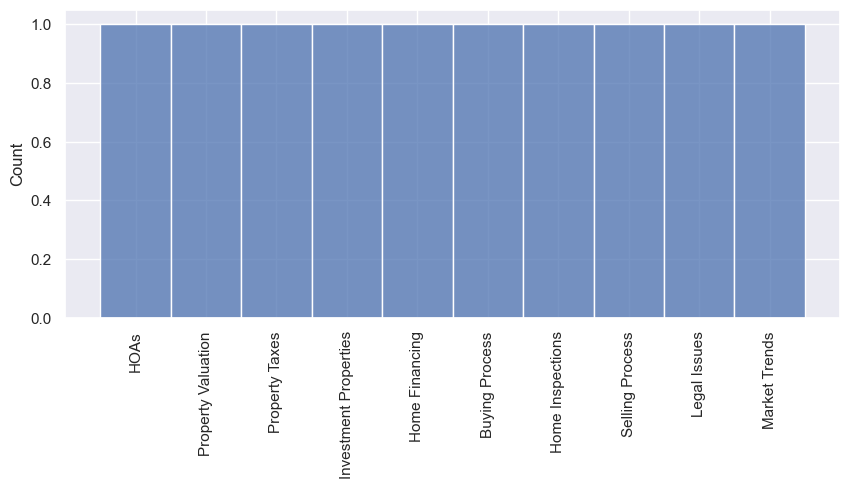

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

topics = [d['topic'] for d in raw_data]

plt.figure(figsize=(10,4))
plt.xticks(rotation=90)
sns.histplot(topics)

In [13]:
import re
from collections import Counter

def extract_scenarios(response):
    scenario_part = response.lower().split('<conversation>')[0].strip()
    pattern = r'\d+\.(\s+.*|^\d+\)\s+.*)'
    matches = re.findall(pattern, scenario_part)
    
    return [m.strip() for m in matches]    
    
    
topic_scenarios = {}
for ex in raw_data:
    scenarios = extract_scenarios(ex['response'])
    topic = ex['topic']
    
    if topic not in topic_scenarios:
        topic_scenarios[topic] = Counter()
    
    topic_scenarios[topic].update(scenarios)

topic_scenarios['HOAs'].most_common(20)

[('understanding the role of an hoa', 1),
 ('benefits of living in a community with an hoa', 1),
 ('common hoa fees and what they cover', 1),
 ('how to find an hoa in a neighborhood', 1),
 ('differences between mandatory and voluntary hoas', 1),
 ('what to do if you disagree with hoa rules', 1),
 ('the process of running for an hoa board', 1),
 ('understanding hoa bylaws and regulations', 1),
 ('how to get involved in your hoa', 1),
 ('consequences of not paying hoa fees', 1),
 ('hoa rules regarding landscaping and maintenance', 1),
 ('how to file a complaint against an hoa', 1),
 ('the impact of hoas on property values', 1),
 ('how to appeal an hoa decision', 1),
 ('understanding the reserve funds of an hoa', 1),
 ('hoa insurance requirements', 1),
 ('what to do if an hoa is not following its own rules', 1),
 ('how to learn about an hoa’s financial health', 1),
 ('the role of hoas in maintaining community standards', 1),
 ('differences between hoas and coas (condominium associations)'

### post process conversations

In [14]:
import re
from collections import Counter

def extract_conversations(response):
    split_token = '<conversation>' if '<conversation>' in response else '<Conversation>'
    conv_part = response.split(split_token)[1].strip()
    
    pattern = r"(User|Assistant): (.+?)(?=(User|Assistant): |$)"
    
    # Find all matches
    matches = re.findall(pattern, conv_part, re.DOTALL)
    
    # Create the list of messages in the required format
    hf_messages = []
    for role, message, _ in matches:
        hf_message = {
            "role": "user" if role == "User" else "assistant",
            "content": message.strip()
        }
        hf_messages.append(hf_message)
    
    return hf_messages
   

all_conversations = []
for ex in raw_data:
    all_conversations.append({'messages': extract_conversations(ex['response']), 'split': 'dialog', 'topic': ex['topic']})
    

Text(0.5, 0, 'number of turns')

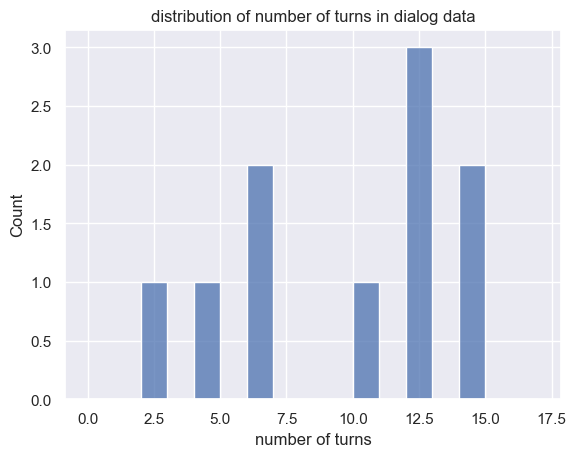

In [15]:
# distribution of conversation lengths

conv_lens = [len(c['messages']) for c in all_conversations]

sns.histplot(conv_lens, bins=np.arange(0, 18, 1))
plt.title("distribution of number of turns in dialog data")
plt.xlabel("number of turns")

### prune and save in chat format

In [16]:
all_conversations = prune_data(all_conversations, threshold=0.9)

with open('data/dialog-chat-all.json', 'w') as f:
    for conv in all_conversations:
        f.write(json.dumps(conv) + '\n')

initial data size:  10


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 32042.05it/s]

pruned data size:  10


## adding ID and splitting data

In [17]:
import json
from uuid import uuid4

non_comp_split = []
instruction_split = []
dialog_split = []

with open('data/safety_all_chat.json', 'r') as f:
    for line in f:
        ex = json.loads(line)
        ex['id'] = str(uuid4())
        non_comp_split.append(ex)
        
with open('data/general-instructions-chat-all.json', 'r') as f:
    for line in f:
        ex = json.loads(line)
        ex['id'] = str(uuid4())
        instruction_split.append(ex)
        
with open('data/dialog-chat-all.json', 'r') as f:
    for line in f:
        ex = json.loads(line)
        ex['id'] = str(uuid4())
        dialog_split.append(ex)
        
print(f"total non compliant: {len(non_comp_split)}")
print(f"total instructions: {len(instruction_split)}")
print(f"total dialogues: {len(dialog_split)}")

total non compliant: 5
total instructions: 6
total dialogues: 10


In [ ]:
import numpy as np
# keeping 600 validation and 600 test examples 200 from each split

np.random.shuffle(non_comp_split)
np.random.shuffle(instruction_split)
np.random.shuffle(dialog_split)


non_comp_val = non_comp_split[:200]
non_comp_test = non_comp_split[200:400]
non_comp_train = non_comp_split[400:]

instruction_val = instruction_split[:200]
instruction_test = instruction_split[200:400]
instruction_train = instruction_split[400:]

dialog_val = dialog_split[:50]
dialog_train = dialog_split[50:]

print(f"non compliant: train: {len(non_comp_train)}, val: {len(non_comp_val)}, test: {len(non_comp_test)}")
print(f"instructions: train: {len(instruction_train)}, val: {len(instruction_val)}, test: {len(instruction_test)}")
print(f"dialogues: train: {len(dialog_train)}, val: {len(dialog_val)}")

In [ ]:

def write_jsonl(data, path):
    with open(path, 'w') as f:
        for ex in data:
            f.write(json.dumps(ex) + '\n')
            
non_comp_100p = non_comp_train
non_comp_50p = non_comp_train[:int(len(non_comp_train)*50/100)]
non_comp_25p = non_comp_train[:int(len(non_comp_train)*25/100)]
non_comp_75p = non_comp_train[:int(len(non_comp_train)*75/100)]


train_100p = non_comp_100p + instruction_train + dialog_train
train_50p = non_comp_50p + instruction_train + dialog_train
train_25p = non_comp_25p + instruction_train + dialog_train
train_75p = non_comp_75p + instruction_train + dialog_train

train_100p_single = non_comp_100p + instruction_train
train_50p_single = non_comp_50p + instruction_train
train_25p_single = non_comp_25p + instruction_train
train_75p_single = non_comp_75p + instruction_train

version = 'v1'

write_jsonl(non_comp_train, f'data/{version}/non_compliant_train.json')
write_jsonl(non_comp_val, f'data/{version}/non_compliant_val.json')
write_jsonl(non_comp_test, f'data/{version}/non_compliant_test.json')
write_jsonl(instruction_train, f'data/{version}/instruction_train.json')
write_jsonl(instruction_val, f'data/{version}/instruction_val.json')
write_jsonl(instruction_test, f'data/{version}/instruction_test.json')
write_jsonl(dialog_train, f'data/{version}/dialog_train.json')
write_jsonl(dialog_val, f'data/{version}/dialog_val.json')
# write_jsonl(dialog_test, f'data/{version}/dialog_test.json')

write_jsonl(train_100p, f'data/{version}/train_100p.json')
write_jsonl(train_50p, f'data/{version}/train_50p.json')
write_jsonl(train_25p, f'data/{version}/train_25p.json')
write_jsonl(train_75p, f'data/{version}/train_75p.json')

write_jsonl(train_100p_single, f'data/{version}/train_100p_single.json')
write_jsonl(train_50p_single, f'data/{version}/train_50p_single.json')
write_jsonl(train_25p_single, f'data/{version}/train_25p_single.json')
write_jsonl(train_75p_single, f'data/{version}/train_75p_single.json')

all_val = non_comp_val + instruction_val + dialog_val
write_jsonl(all_val, f'data/{version}/validation_all.json')


# Nearest neighbor analysis of data

In [18]:
import json


def load_jsonl(path):
    data = []
    with open(path, 'r') as f:
        for line in f:
            data.append(json.loads(line))
    return data


def convert_to_string_chat(example, only_query=False):
    chat_str = ""
    for turn in example['messages']:
        if not only_query:
            chat_str = chat_str + f"{turn['role']}: {turn['content']}\n\n"
        else:
            if turn['role'] == 'user':
                chat_str += f"{turn['content']}\n"
    return chat_str

# instruction_data = load_jsonl('data/ft-v5/instruction_train.json')
# instruction_data = [convert_to_string_chat(x) for x in instruction_data]

# instruction_test_data = load_jsonl('data/ft-v5/instruction_test.json')
# instruction_test_data = [convert_to_string_chat(x) for x in instruction_test_data]


## similarity between training samples

/Users/navidm/miniconda3/envs/compllm/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning:

`clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884



data size:  6


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

similarity shape: (6, 6)


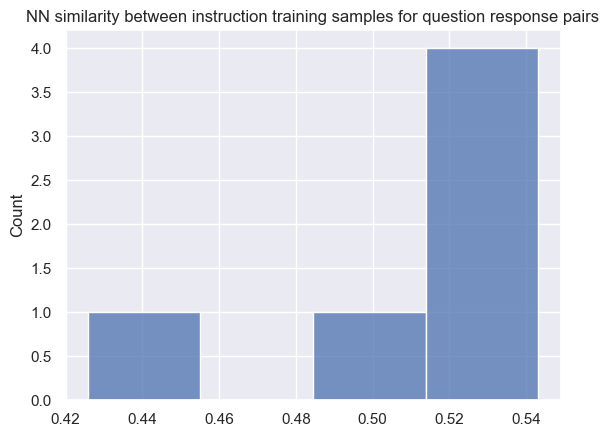

data size:  6


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

similarity shape: (6, 6)


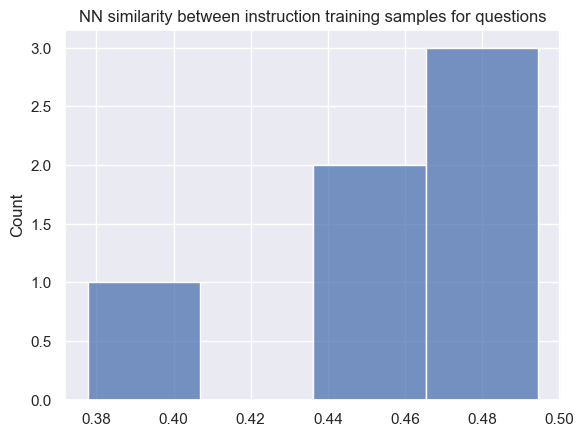

In [19]:
from sentence_transformers import SentenceTransformer
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

model = SentenceTransformer("all-mpnet-base-v2")
# non_comp_data = load_jsonl('data/ft-v5/non_compliant_train.json')
inst_data = load_jsonl('data/general-instructions-chat-all.json')
# dialog_data = load_jsonl('data/ft-v5/dialog_train.json')

def plot_nn_sim(data, title="", only_query=False):
    print("data size: ", len(data))
    data = [convert_to_string_chat(x, only_query=only_query) for x in data]
    embeddings = model.encode(data, batch_size=128, show_progress_bar=True)
    similarity_mat = embeddings @ embeddings.T
    print("similarity shape:", similarity_mat.shape)
    nn_similarity = np.sort(similarity_mat, axis=1)[:, -2]
    

    sns.histplot(nn_similarity)
    plt.title(title)
    plt.show()

# plot_nn_sim(non_comp_data, title='NN similarity between non-comp training samples for question response pairs')
plot_nn_sim(inst_data, title='NN similarity between instruction training samples for question response pairs')
# plot_nn_sim(dialog_data, title='NN similarity between dialog training samples for question response pairs')

# plot_nn_sim(non_comp_data, title='NN similarity between non-comp training samples for questions', only_query=True)
plot_nn_sim(inst_data, title='NN similarity between instruction training samples for questions', only_query=True)
# plot_nn_sim(dialog_data, title='NN similarity between dialog training samples for questions', only_query=True)

## similarity of train and test 

In [ ]:
import numpy as np

embeddings = model.encode(instruction_data, batch_size=128, show_progress_bar=True)
test_embeddings = model.encode(instruction_test_data, batch_size=128, show_progress_bar=True)


similarity_mat = test_embeddings @ embeddings.T
similarity_mat.shape

In [ ]:
nn_similarity = np.sort(similarity_mat, axis=1)[:, -1]
nn_similarity[:10]

In [ ]:
import seaborn as sns

sns.histplot(nn_similarity, bins=np.arange(0.4, 1.0, 0.01))